In [1]:
from functions import *
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
params = read_parameters()
file_idx = params['file_idx']
x_axis = params['x_axis']
x_format = X_AXIS_FORMAT[x_axis]
# always exclude outliers here
include_outliers = False
is_outlier = None

parameters:
x_axis: time [m]
file_idx_uppaal: 0
file_idx: 5
tmp_idx: 0
log: True
plot_scatterplot_matrix: False
use_default_arima_params: True
default_arima_params: [1, 1, 0]
include_arima_simulations_in_analysis: True
include_outliers: False
mark_outliers: True


In [3]:
in_folder=PATH_SENSORS_DATA_EXT_UF_V1
cur_file, file_path = get_input_file(in_folder=in_folder, in_file_idx=file_idx, log=True)

file list:
0 /app/data/from_sensors/1_extended/UF/v1/2024-07-11 #1 tap water - reflux valve closed.csv
1 /app/data/from_sensors/1_extended/UF/v1/2024-07-12 #1 tap water - reflux valve open.csv
2 /app/data/from_sensors/1_extended/UF/v1/2024-07-15 #1 wastewater 0.500 gL - reflux valve open.csv
3 /app/data/from_sensors/1_extended/UF/v1/2024-07-16 #1 wastewater 0.250 gL - reflux valve open.csv
4 /app/data/from_sensors/1_extended/UF/v1/2024-07-16 #2 wastewater 0.125 gL - reflux valve open.csv
5 /app/data/from_sensors/1_extended/UF/v1/ALL_DATA.csv

input file:
/app/data/from_sensors/1_extended/UF/v1/ALL_DATA.csv


In [4]:
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
df = identify_all_outliers(df, drop_outliers=(not include_outliers), log=True)
df = identify_TMP_groups(
    df, series_col='TMP [kPa]', group_col='TMP group', drop_outliers=(not include_outliers), log=True,
    max_distance_from_average=MAX_DISTANCE_FROM_TMP_AVERAGE, min_size=MIN_OBSERVATIONS_PER_TMP_GROUP)
if cur_file != ALL_DATA_FILE :
    df = add_cross_flow_velocity_and_estimated_retentate_flow(df, cur_file)
df = add_estimate_retentate_pressure(
    df, target_col='prs retentate [kPa]', group_by_cols=['TMP group'])

dropped all outliers.
 - total number of outliers: 0 -> 0
added column: 'TMP group', computed by checking if the current point is near the moving average of the previous points (max_distance_from_average=12.5)
dropped all outliers.
 - total number of outliers: 0 -> 0
added column: 'prs retentate est [kPa]', estimated by taking the median value of its group


In [6]:
conc_lines, conc_lines_GREATER_ZERO = generate_concentration_lines(df, x_axis)

feed concentrations found (time [m]: concentration)
   1: feed conc = 0.00 [g/L]
 303: feed conc = 0.50 [g/L]
 442: feed conc = 0.25 [g/L]
 538: feed conc = 0.12 [g/L]


In [7]:
# estimate factors excluding clear water samples
if len(conc_lines) > 1 :
    df = df[df['initial feed concentration [g/L]'] > 0]
    conc_lines = conc_lines_GREATER_ZERO

        prs retentate [kPa]  absolute error  relative error  squared error
min              104.437900        0.000000        0.000000       0.000000
median           223.479100        1.853650        0.007806       3.438057
mean             249.814499        2.504703        0.012105      13.119090
max              393.428100       30.110700        0.125777     906.654254
var             8684.786122        6.865170        0.000239    2729.796336
std               93.192200        2.620147        0.015468      52.247453

Error metrics:
R^2      0.9985
RMSE     3.6220
MAE      2.5047
MedAE    1.8536
maxAE   30.1107
MAPE     0.0121
maxAPE   0.1258


<module 'matplotlib.pyplot' from '/opt/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

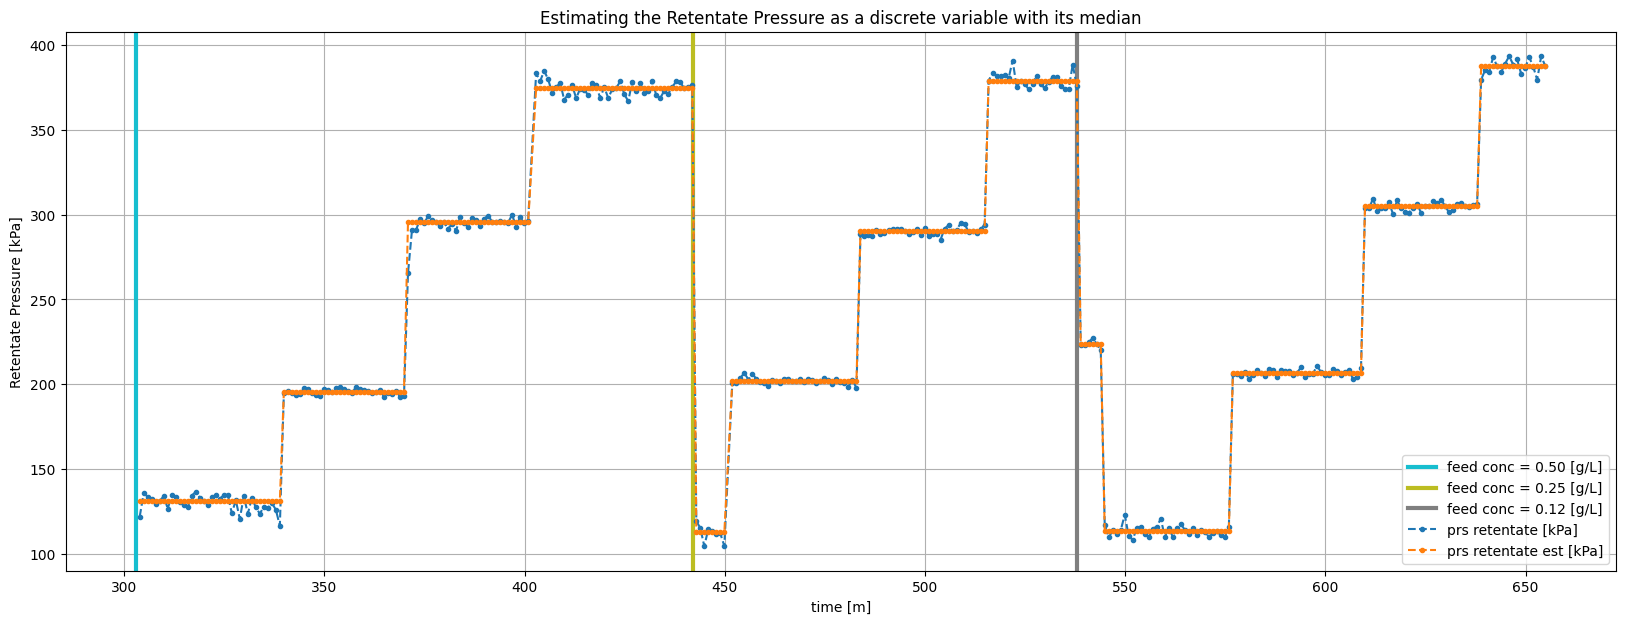

In [8]:
title='Estimating the Retentate Pressure as a discrete variable with its median'
x_col = 'prs retentate est [kPa]'
x = df[[x_col]]
y_col = 'prs retentate [kPa]'
y_ax_lbl = 'Retentate Pressure [kPa]'
y = df[y_col]
y_pred = df[x_col]
y_dict = {
    y_col   : y,
    x_col   : y_pred,
}
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, 
    y_ax_lbl=y_ax_lbl, title=title, concentration_lines=conc_lines)
#if cur_file == ALL_DATA_FILE :
#    plot.savefig(f'{PATH_IMAGES}/retentate_pressure_vs_median.png')

pressure permeate median: 28.1214 (excluding clear water samples if possible)

        prs permeate [kPa]  absolute error  relative error  squared error
min              26.312900        0.000000        0.000000       0.000000
median           28.121400        0.452100        0.015822       0.204394
mean             28.096585        0.525996        0.018728       0.446094
max              29.658600        1.808500        0.068731       3.270672
var               0.446754        0.169907        0.000215       0.332871
std               0.668397        0.412198        0.014658       0.576950

Error metrics:
R^2     -0.0014
RMSE     0.6679
MAE      0.5260
MedAE    0.4521
maxAE    1.8085
MAPE     0.0187
maxAPE   0.0687


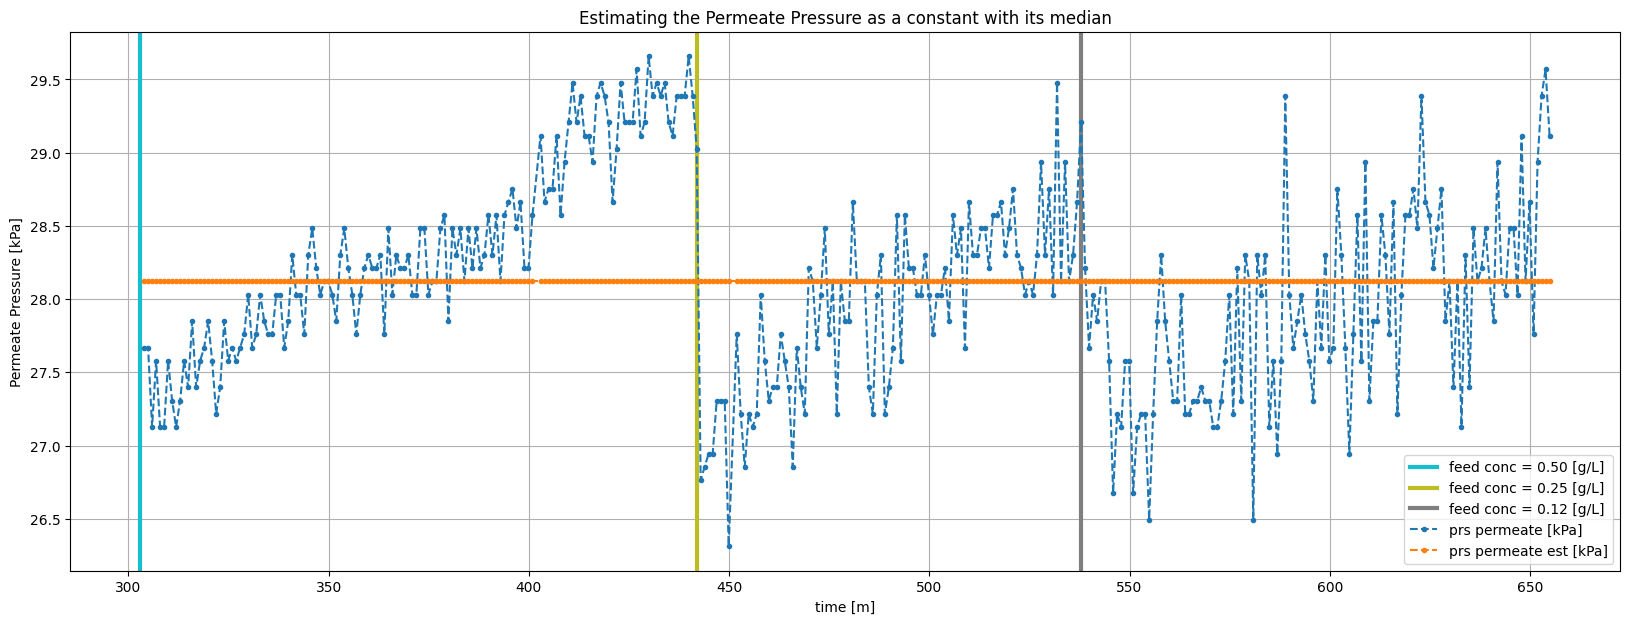

In [9]:
# ESTIMATING PERMEATE PRESSURE
title='Estimating the Permeate Pressure as a constant with its median'
x_col = 'prs permeate est [kPa]'
y_col = 'prs permeate [kPa]'
y_ax_lbl = 'Permeate Pressure [kPa]'
y = df[y_col]
PRS_PERMEATE_EST = y.median()
df[x_col] = PRS_PERMEATE_EST
y_pred = df[x_col]
y_dict = {
    y_col   : y,
    x_col   : y_pred,
}
print(f"pressure permeate median: {PRS_PERMEATE_EST} (excluding clear water samples if possible)\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
cur_ax = plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title=title, concentration_lines=conc_lines)
#cur_ax.ylim(0,600)
if cur_file == ALL_DATA_FILE :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=y_col, x_cols=None, intercept=PRS_PERMEATE_EST, coefficients=[])
    plot.savefig(f'{PATH_IMAGES}/linear_model_permeate_pressure.png')

In [10]:
if cur_file != ALL_DATA_FILE :
    y_dict = {
        'cross flow velocity' : df['vlct crsflow [m/s]'],
        'TMP' : df['TMP [kPa]']
    }
    y_ax_lbl = ['cross flow velocity [m/s]', 'TMP [kPa]']
    plot_time_series_2_axis(
        x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
        title='Cross-Flow Velocity and TMP over time', 
        x_format=x_axis, secondary_y=['TMP'], is_outlier=is_outlier)

In [11]:
if cur_file != ALL_DATA_FILE :
    # ESTIMATING RETENTATE FLOW
    # TODO TO IMPROVE.. include conc_feed [g/L] !
    x = df[['flow retentate est by vlct crsflow [L/h]']]
    y_col = 'flow retentate [L/h]'
    y = df[y_col]
    model, y_pred, intercept, coeffs = call_linear_model(x, y)
    y_dict = {
        'flow retentate real'  : y,
        'flow retentate estimated by formula' : df['flow retentate est by vlct crsflow [L/h]'],
        #'flow retentate estimated by formula + lm'  : y_pred,
    }
    title = 'Physics Model of Retentate Flow (based on cross-flow velocity)'
    y_ax_lbl=y_col
    plot_time_series_1_axis(
        x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
        title=title, x_format=x_axis, is_outlier=is_outlier)

 291: feed conc = 0.50 [g/L]
 429: feed conc = 0.25 [g/L]
 524: feed conc = 0.12 [g/L]

Intercept:    3079.300299090882
Coefficients: [-7.550306017233438]
                             OLS Regression Results                             
Dep. Variable:     flow retentate [L/h]   R-squared:                       0.963
Model:                              OLS   Adj. R-squared:                  0.963
Method:                   Least Squares   F-statistic:                     9005.
Date:                  Thu, 09 Jan 2025   Prob (F-statistic):          8.45e-251
Time:                          09:52:38   Log-Likelihood:                -2220.5
No. Observations:                   350   AIC:                             4445.
Df Residuals:                       348   BIC:                             4453.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                              coef 

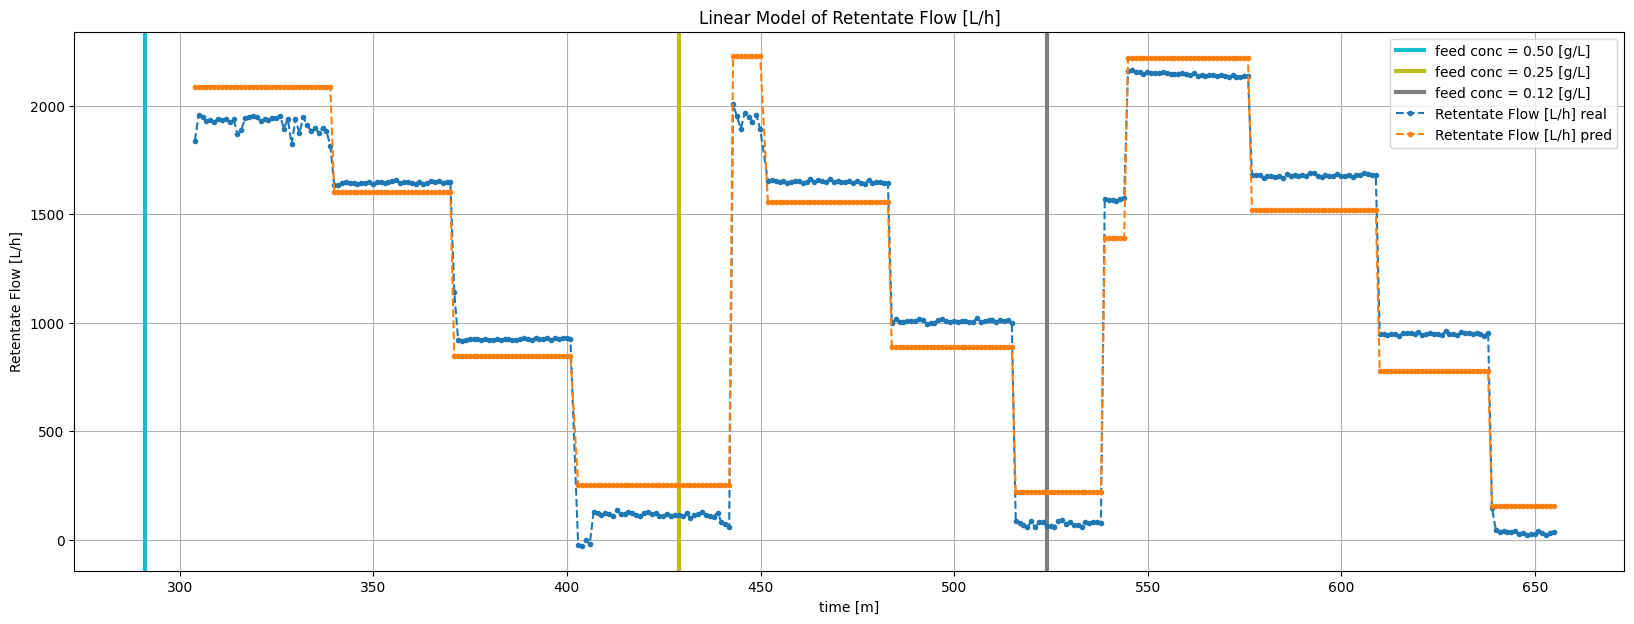

In [12]:
# ESTIMATING RETENTATE FLOW
# TODO TO IMPROVE.. include conc_feed [g/L] !
cur_df = df
cur_df = cur_df[cur_df['initial feed concentration [g/L]'] > 0]
if len(cur_df) <= 5 :
    cur_df = df

cur_conc_lines, _ = get_concentration_lines(cur_df, time_col='index')

y_ax_lbl = 'Retentate Flow [L/h]'
title = 'Linear Model of ' + y_ax_lbl

x_cols = ['prs retentate est [kPa]'] 
x = cur_df[x_cols] 
#'flow permeate [L/h]', 'TMP est [kPa]', 'initial permeate concentration [g/L]', 'initial feed concentration [g/L]', 
#'prs retentate [kPa]', 'res tot [1/m]', 'viscosity permeate [Pa s]', 'flow permeate [L/h]'
y_col = 'flow retentate [L/h]'
y = cur_df[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
df['flow retentate est [kPa]'] = y_pred
# value obtained from the model containing all the samples with initial feed concentration > 0
#y_fixed   = predict_y(x, 2841.34618760, [-6.50123444])
y_dict = {
    y_ax_lbl + ' real'  : y,
    y_ax_lbl + ' pred'  : y_pred,
}
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(
    x=cur_df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title=title, x_format=x_format, concentration_lines=cur_conc_lines)
del(cur_df)
if cur_file == ALL_DATA_FILE :
    write_estimated_coefficients_to_json(
        FILE_EST_COEFFS, key=y_col, x_cols=x_cols, intercept=intercept, coefficients=coeffs)
    plot.savefig(f'{PATH_IMAGES}/linear_model_retentate_flow.png')


Intercept:    25.364726051906906
Coefficients: [0.005840345595118899]
                            OLS Regression Results                            
Dep. Variable:       prs feed_1 [kPa]   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     779.3
Date:                Thu, 09 Jan 2025   Prob (F-statistic):           7.74e-91
Time:                        09:52:39   Log-Likelihood:                -141.15
No. Observations:                 350   AIC:                             286.3
Df Residuals:                     348   BIC:                             294.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

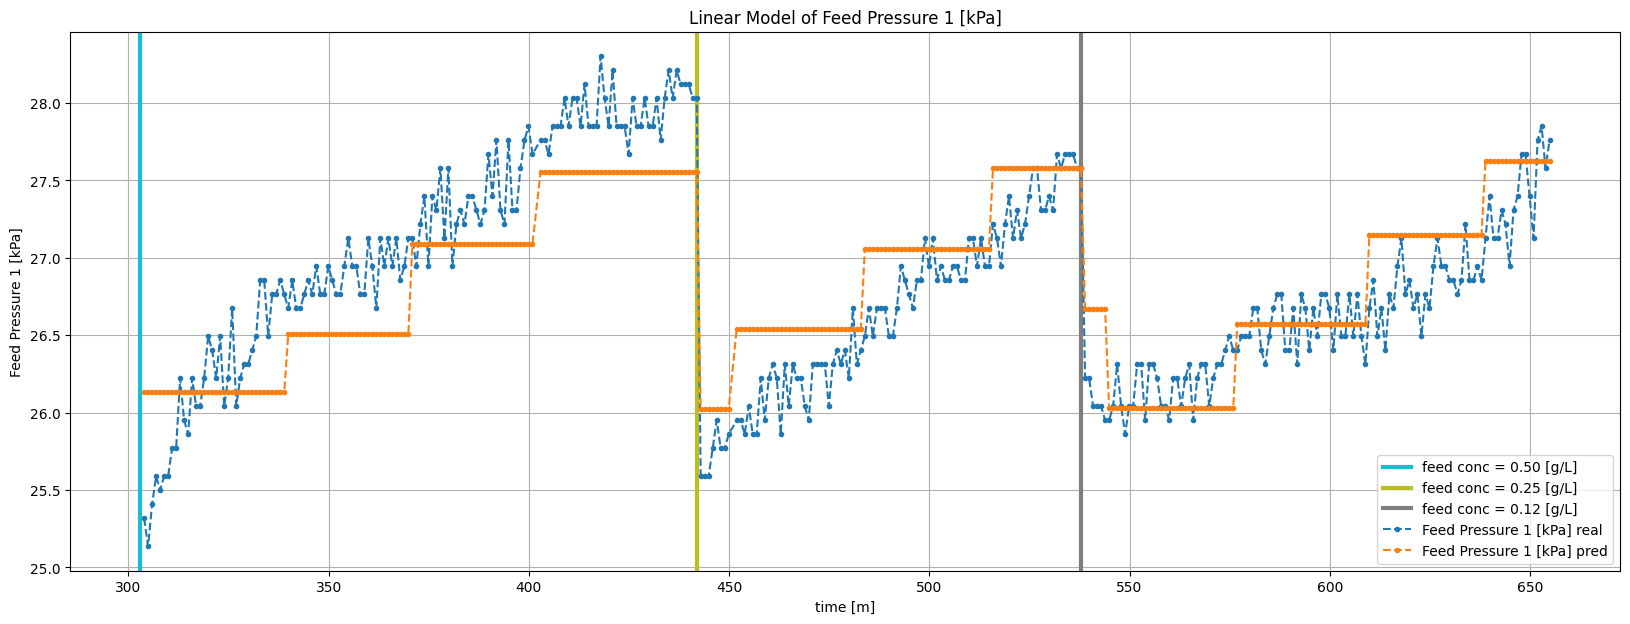

In [13]:
# ESTIMATING PRESSURE PUMP OULET PRESSURE
y_ax_lbl = 'Feed Pressure 1 [kPa]'
title = 'Linear Model of ' + y_ax_lbl
x_cols = ['prs retentate est [kPa]']
x = df[x_cols]
y_col = 'prs feed_1 [kPa]'
y = df[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
df['prs feed_1 est [kPa]'] = y_pred
#y_fixed = predict_y(x, 32, [1])
y_dict = {
    y_ax_lbl + ' real'  : y,
    y_ax_lbl + ' pred'  : y_pred,
}
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title=title, x_format=x_format, concentration_lines=conc_lines)
#cur_ax.ylim(0,600)
if cur_file == ALL_DATA_FILE :
    write_estimated_coefficients_to_json(
        FILE_EST_COEFFS, key=y_col, x_cols=x_cols, intercept=intercept, coefficients=coeffs)
    plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_1.png')


Intercept:    262.8044873512639
Coefficients: [0.9706707580528723]
                            OLS Regression Results                            
Dep. Variable:       prs feed_2 [kPa]   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.792e+05
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:52:39   Log-Likelihood:                -979.10
No. Observations:                 350   AIC:                             1962.
Df Residuals:                     348   BIC:                             1970.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

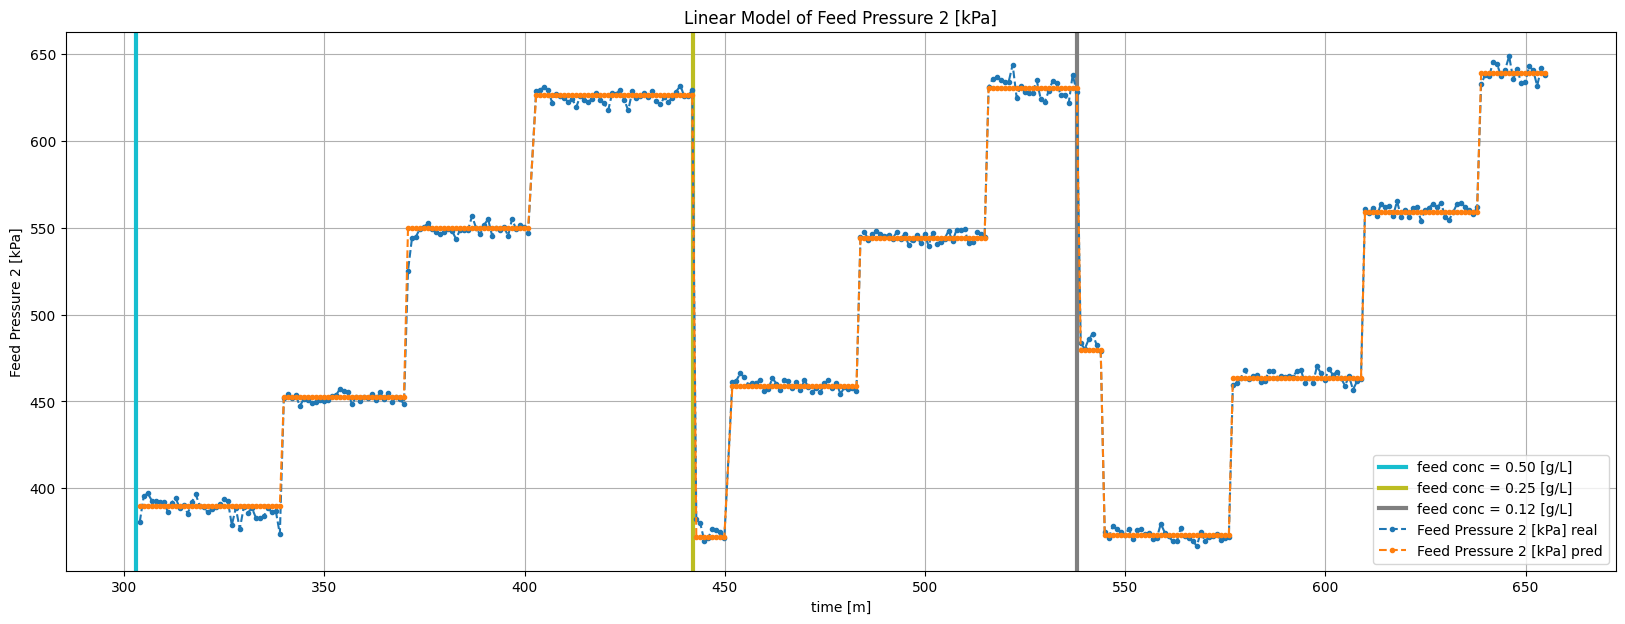

In [14]:
# ESTIMATING CIRCULATION PUMP OULET PRESSURE == FEED PRESSURE ON THE MEMBRANE
y_ax_lbl = 'Feed Pressure 2 [kPa]'
title = 'Linear Model of ' + y_ax_lbl
x_cols = ['prs retentate est [kPa]']
x = df[x_cols]
y_col = 'prs feed_2 [kPa]'
y = df[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
df['prs feed_2 est [kPa]'] = y_pred
y_dict = {
    y_ax_lbl + ' real'  : y,
    y_ax_lbl + ' pred'  : y_pred,
}
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format, concentration_lines=conc_lines)
if cur_file == ALL_DATA_FILE :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=y_col, x_cols=x_cols, intercept=intercept, coefficients=coeffs)
    plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_2.png')

        prs feed_2 [kPa]  absolute error  relative error  squared error
min           366.663100        0.050579        0.000092       0.002558
median        483.081950        2.537707        0.004941       6.439955
mean          505.500261        3.013981        0.006134      15.752339
max           648.781100       24.283879        0.046224     589.706768
var          8152.639037        6.687363        0.000031    1601.920752
std            90.291966        2.585994        0.005609      40.024002

Error metrics:
R^2      0.9981
RMSE     3.9689
MAE      3.0140
MedAE    2.5377
maxAE   24.2839
MAPE     0.0061
maxAPE   0.0462


<module 'matplotlib.pyplot' from '/opt/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

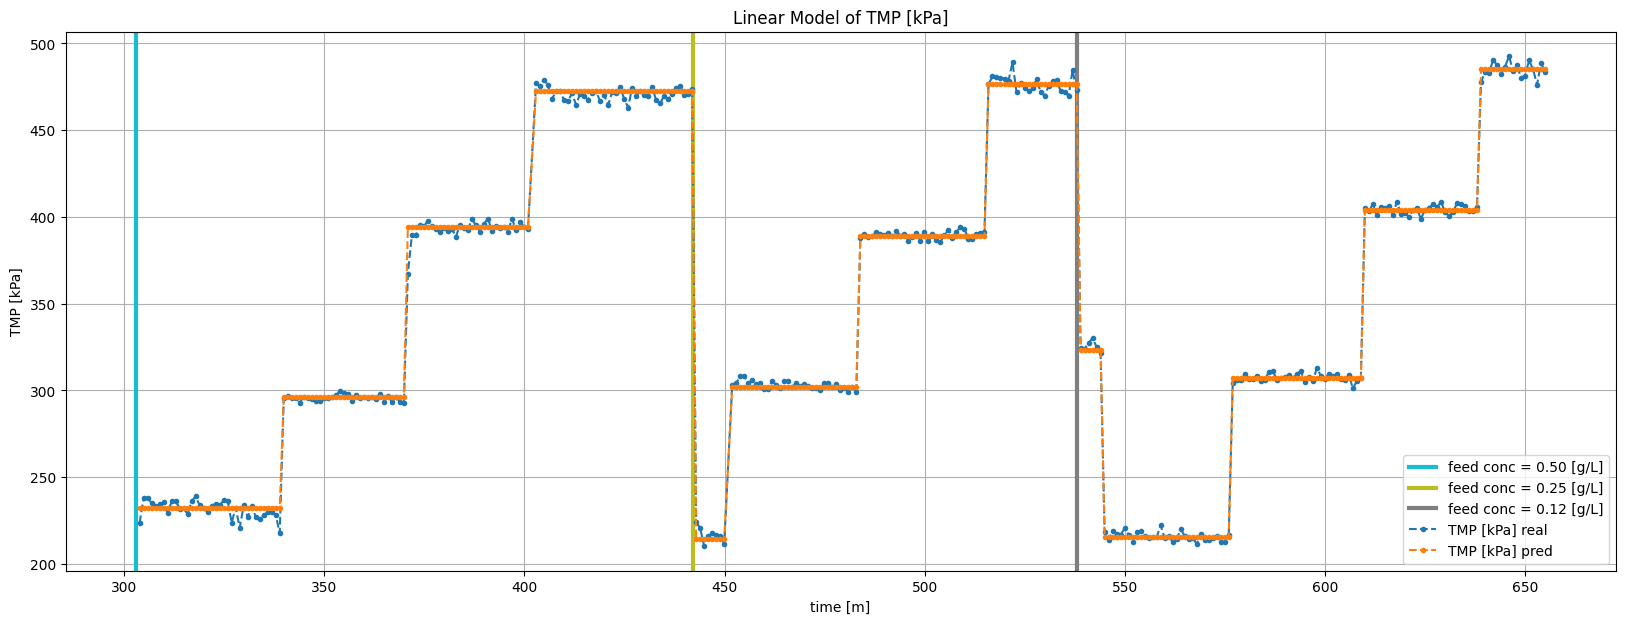

In [15]:
# checking TMP estimated
y_ax_lbl = 'TMP [kPa]'
title = 'Linear Model of ' + y_ax_lbl
df['TMP est [kPa]'] = 0.5 * (df['prs feed_2 est [kPa]'] + df['prs retentate est [kPa]']) - df['prs permeate est [kPa]'] 
y_dict = {
    y_ax_lbl + ' real'  : df['TMP [kPa]'],
    y_ax_lbl + ' pred'  : df['TMP est [kPa]'],
}
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title=title, x_format=x_format, concentration_lines=conc_lines)

average pressure permeate: 28.1214
Variance Inflation Factor (VIF)
 - temperature [°C]      -> 26.70 ==> Severe multicollinearity, the model coefficients can be poorly estimated
 - sqrt temperature [°C] -> 26.70 ==> Severe multicollinearity, the model coefficients can be poorly estimated

Intercept:    0.0022436217495842518
Coefficients: [1.4967977799090422e-05, -0.0003456051788437649]
                            OLS Regression Results                            
Dep. Variable:       temperature [°C]   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.894e+05
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:52:40   Log-Likelihood:                 2809.7
No. Observations:                 260   AIC:                            -5613.
Df Residuals:                     257   BIC:              

<module 'matplotlib.pyplot' from '/opt/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

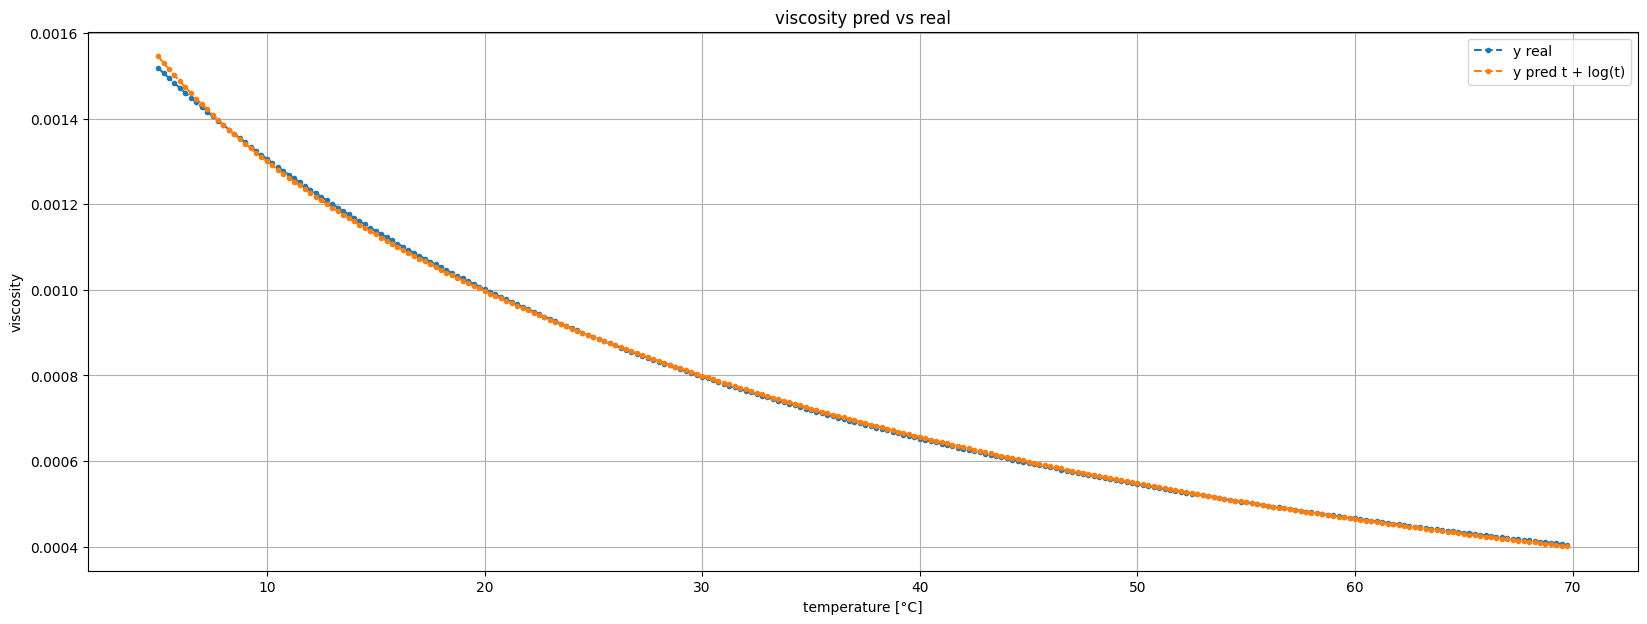

In [16]:
# ESTIMATING VISCOSITY
# since we assume constant permeate pressure, only temperature will be included in the model
# NB ok only for temperature >= 5 and <70, which is our interval of interest
# better model for 1 <= temperature <= 100 including also log temperature
# normally ultrafiltration [5,70] is enough, actually tipically <= 50
print("average pressure permeate:", PRS_PERMEATE_EST)
df_visc = pd.DataFrame()
df_visc['temperature [°C]'] = list(np.arange(5, 70, 0.25))
#df_visc['log temperature [°C]'] = df_visc['temperature [°C]'].apply(lambda x : math.log(x))
df_visc['sqrt temperature [°C]'] = df_visc['temperature [°C]'].apply(lambda x : math.sqrt(x))
x = df_visc[['temperature [°C]', 'sqrt temperature [°C]']]
y = df_visc['temperature [°C]'].apply(lambda x : calc_viscosity(x, pressure_Pa=((1000*PRS_ATM_kpa)+PRS_PERMEATE_EST), element='Water'))
df_visc['viscosity [Pa s]'] = y
model, y_pred, intercept, coeffs = call_linear_model(x, y)
y_dict = {
    'y real'          : y,
    'y pred t + log(t)'  : y_pred,
}
title = 'viscosity pred vs real'
y_ax_lbl='viscosity'
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, 'viscosity [Pa s]'))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=df_visc['temperature [°C]'], y_series=y_dict, x_ax_lbl='temperature [°C]', y_ax_lbl=y_ax_lbl, title=title, x_format=None)